In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter, gaussian_gradient_magnitude
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt


In [ ]:
def generate_scale_space(image, num_octaves=4, num_scales=5, sigma=1.6):
    octaves = []
    for octave in range(num_octaves):
        scales = []
        k = 2 ** (1 / num_scales)
        for scale in range(num_scales):
            sigma_scale = sigma * (k ** scale)
            blurred_image = gaussian_filter(image, sigma=sigma_scale)
            scales.append(blurred_image)
        octaves.append(scales)
        image = scales[-3][::2, ::2]
    return octaves

def difference_of_gaussians(octaves):
    dog_octaves = []
    for octave in octaves:
        dog_octave = []
        for i in range(len(octave) - 1):
            dog_octave.append(octave[i + 1] - octave[i])
        dog_octaves.append(dog_octave)
    return dog_octaves


In [ ]:
def find_keypoints(dog_octaves, contrast_threshold=0.04):
    keypoints = []
    for o, octave in enumerate(dog_octaves):
        for s in range(1, len(octave) - 1):
            current = octave[s]
            prev = octave[s - 1]
            next_ = octave[s + 1]
            for i in range(1, current.shape[0] - 1):
                for j in range(1, current.shape[1] - 1):
                    pixel_val = current[i, j]
                    if abs(pixel_val) > contrast_threshold:
                        is_extremum = np.all(pixel_val >= prev[i-1:i+2, j-1:j+2]) and \
                                      np.all(pixel_val >= current[i-1:i+2, j-1:j+2]) and \
                                      np.all(pixel_val >= next_[i-1:i+2, j-1:j+2])
                        if is_extremum:
                            keypoints.append((o, s, i, j))  # (octave, scale, row, col)
    return keypoints


In [ ]:
'''def compute_orientation(image, keypoint, radius=8):
    x, y = keypoint[2], keypoint[3]
    gradient_magnitudes = []
    gradient_orientations = []

    for i in range(-radius, radius+1):
        for j in range(-radius, radius+1):
            if x+i > 0 and x+i < image.shape[0] and y+j > 0 and y+j < image.shape[1]:
                dx = image[x+i, y+j+1] - image[x+i, y+j-1]
                dy = image[x+i+1, y+j] - image[x+i-1, y+j]
                magnitude = np.sqrt(dx**2 + dy**2)
                orientation = np.degrees(np.arctan2(dy, dx)) % 360
                gradient_magnitudes.append(magnitude)
                gradient_orientations.append(orientation)

    # Histogram of orientations
    orientation_histogram = np.zeros(36)
    for magnitude, orientation in zip(gradient_magnitudes, gradient_orientations):
        bin_index = int(orientation // 10)  # Each bin is 10 degrees
        orientation_histogram[bin_index] += magnitude

    dominant_orientation = np.argmax(orientation_histogram) * 10
    return dominant_orientation
'''
def compute_orientation(image, keypoint, radius=8, plot_histogram=True):
    x, y = keypoint[2], keypoint[3]
    gradient_magnitudes = []
    gradient_orientations = []

    # Compute gradient magnitudes and orientations around the keypoint
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if (0 < x + i < image.shape[0] - 1) and (0 < y + j < image.shape[1] - 1):
                dx = image[x + i, y + j + 1] - image[x + i, y + j - 1]
                dy = image[x + i + 1, y + j] - image[x + i - 1, y + j]
                magnitude = np.sqrt(dx**2 + dy**2)
                orientation = np.degrees(np.arctan2(dy, dx)) % 360
                gradient_magnitudes.append(magnitude)
                gradient_orientations.append(orientation)

    # Create orientation histogram
    orientation_histogram = np.zeros(36)
    for magnitude, orientation in zip(gradient_magnitudes, gradient_orientations):
        bin_index = int(orientation // 10)  # Each bin is 10 degrees
        orientation_histogram[bin_index] += magnitude

    # Find the dominant orientation
    dominant_orientation = np.argmax(orientation_histogram) * 10

    # Plot the orientation histogram if requested
    '''if plot_histogram:
        plt.figure(figsize=(8, 4))
        bin_edges = np.arange(0, 360, 10)
        plt.bar(bin_edges, orientation_histogram, width=10, color='blue', edgecolor='black', align='edge')
        plt.title("Orientation Histogram")
        plt.xlabel("Orientation (degrees)")
        plt.ylabel("Magnitude Sum")
        plt.xticks(bin_edges)
        plt.show()'''

    return dominant_orientation

In [ ]:
''' def generate_descriptor(image, keypoint, orientation, grid_size=4, bin_size=8):
    x, y = keypoint[2], keypoint[3]
    descriptor = np.zeros((grid_size, grid_size, bin_size))
    angle_offset = orientation

    for i in range(-grid_size//2, grid_size//2):
        for j in range(-grid_size//2, grid_size//2):
            if x+i > 0 and x+i < image.shape[0] and y+j > 0 and y+j < image.shape[1]:
                dx = image[x+i, y+j+1] - image[x+i, y+j-1]
                dy = image[x+i+1, y+j] - image[x+i-1, y+j]
                magnitude = np.sqrt(dx**2 + dy**2)
                orientation = (np.degrees(np.arctan2(dy, dx)) - angle_offset) % 360
                bin_index = int(orientation // (360 / bin_size))
                descriptor[i + grid_size//2, j + grid_size//2, bin_index] += magnitude

    # Normalize the descriptor
    descriptor = descriptor.flatten()
    descriptor = descriptor / np.linalg.norm(descriptor)
    return descriptor
'''
def generate_descriptor(image, keypoint, orientation, grid_size=4, bin_size=8):
    x, y = keypoint[2], keypoint[3]
    descriptor = np.zeros((grid_size, grid_size, bin_size))
    angle_offset = orientation

    for i in range(-grid_size // 2, grid_size // 2):
        for j in range(-grid_size // 2, grid_size // 2):
            if (0 < x + i < image.shape[0] - 1) and (0 < y + j < image.shape[1] - 1):
                dx = image[x + i, y + j + 1] - image[x + i, y + j - 1]
                dy = image[x + i + 1, y + j] - image[x + i - 1, y + j]
                magnitude = np.sqrt(dx**2 + dy**2)
                orientation = (np.degrees(np.arctan2(dy, dx)) - angle_offset) % 360
                bin_index = int(orientation // (360 / bin_size))
                descriptor[i + grid_size // 2, j + grid_size // 2, bin_index] += magnitude

    # Flatten and normalize the descriptor
    descriptor = descriptor.flatten()
    norm = np.linalg.norm(descriptor)
    if norm != 0:
        descriptor = descriptor / norm
    return descriptor


In [ ]:
def match_keypoints(descriptors1, descriptors2, threshold=0.75):
    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = [euclidean(desc1, desc2) for desc2 in descriptors2]
        sorted_indices = np.argsort(distances)

        # Apply Lowe's ratio test
        if distances[sorted_indices[0]] < threshold * distances[sorted_indices[1]]:
            matches.append((i, sorted_indices[0]))
    return matches


In [ ]:
from google.colab import files
from PIL import Image
import numpy as np

# Upload images
uploaded_images1 = files.upload()
uploaded_images2 = files.upload()

# Get file paths from the uploaded images
image_path1 = next(iter(uploaded_images1))
image_path2 = next(iter(uploaded_images2))

# Load the images as grayscale
image1 = Image.open(image_path1).convert('L')
image2 = Image.open(image_path2).convert('L')

# Convert images to numpy arrays
# Convert images to float32 type for gradient calculations
image1_np = np.array(image1, dtype=np.float32)
image2_np = np.array(image2, dtype=np.float32)


Saving alma.jpg to alma.jpg


Saving alma2.jpg to alma2.jpg


In [ ]:
# Generate scale space, DoG, find keypoints, and compute descriptors
octaves1 = generate_scale_space(image1_np)
dog_octaves1 = difference_of_gaussians(octaves1)
keypoints1 = find_keypoints(dog_octaves1)
descriptors1 = [generate_descriptor(image1_np, kp, compute_orientation(image1_np, kp)) for kp in keypoints1]

octaves2 = generate_scale_space(image2_np)
dog_octaves2 = difference_of_gaussians(octaves2)
keypoints2 = find_keypoints(dog_octaves2)
descriptors2 = [generate_descriptor(image2_np, kp, compute_orientation(image2_np, kp)) for kp in keypoints2]

# Match descriptors
matches = match_keypoints(descriptors1, descriptors2)
print(f"Number of matches between images: {len(matches)}")


Number of matches between images: 17


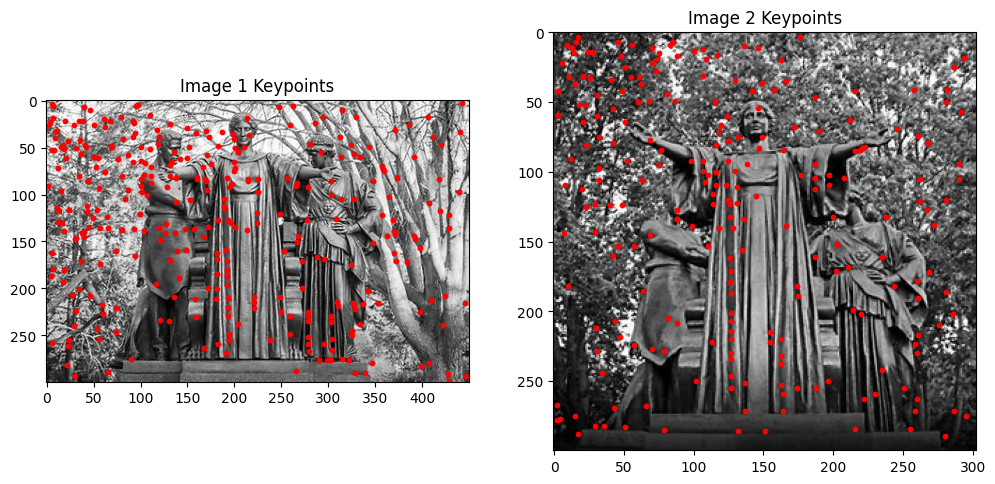

In [ ]:
import matplotlib.pyplot as plt

# Display keypoints for each image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image1_np, cmap='gray')
plt.scatter([kp[3] for kp in keypoints1], [kp[2] for kp in keypoints1], c='r', s=10)
plt.title("Image 1 Keypoints")

plt.subplot(1, 2, 2)
plt.imshow(image2_np, cmap='gray')
plt.scatter([kp[3] for kp in keypoints2], [kp[2] for kp in keypoints2], c='r', s=10)
plt.title("Image 2 Keypoints")

plt.show()


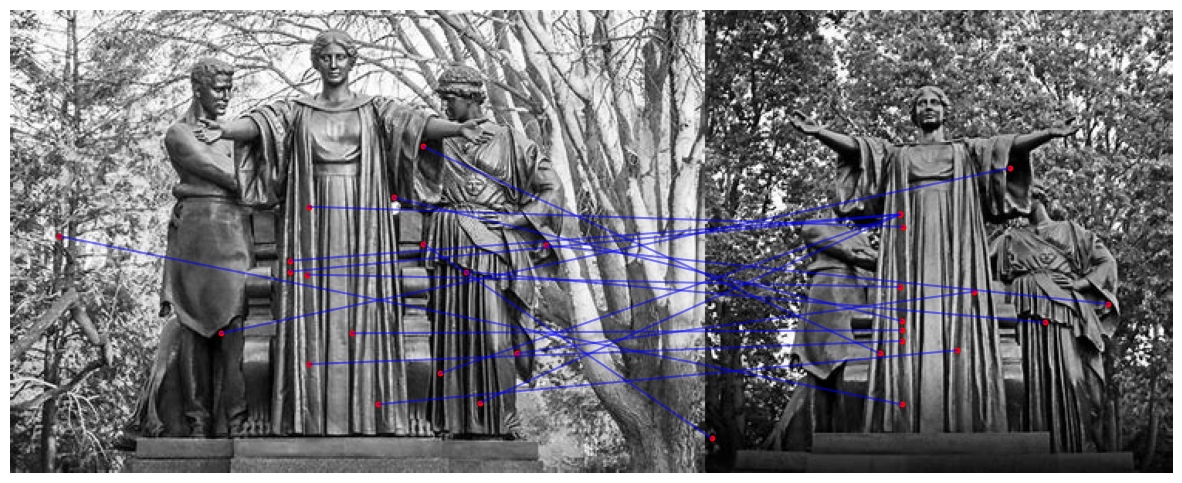

In [ ]:

from skimage.transform import resize

# Function to resize and plot matches on concatenated images
def plot_matches(image1, keypoints1, image2, keypoints2, matches):
    # Resize images to the same height
    if image1.shape[0] != image2.shape[0]:
        target_height = min(image1.shape[0], image2.shape[0])
        image1 = resize(image1, (target_height, image1.shape[1]), anti_aliasing=True)
        image2 = resize(image2, (target_height, image2.shape[1]), anti_aliasing=True)

    # Concatenate images horizontally
    combined_image = np.concatenate((image1, image2), axis=1)

    # Plot the concatenated image
    plt.figure(figsize=(15, 8))
    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')

    # Extract matched keypoints' positions and draw connections
    for match in matches:
        idx1, idx2 = match
        kp1 = keypoints1[idx1]
        kp2 = keypoints2[idx2]

        # Get coordinates of the keypoints in both images
        x1, y1 = kp1[3], kp1[2]
        x2, y2 = kp2[3] + image1.shape[1], kp2[2]  # Shift x-coord by width of image1 for image2 keypoints

        # Plot keypoints
        plt.scatter([x1, x2], [y1, y2], c='r', s=10)

        # Draw line connecting the keypoints
        plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.5)

    plt.show()

# Call the function with your data
plot_matches(image1_np, keypoints1, image2_np, keypoints2, matches)
